# D2 Data Analysis/Exploration

This notebook is prepared to explore politeness statistics from the Switchboard corpus.

In [1]:
import os
os.chdir("../../") # import convokit
from convokit import Corpus, User, Utterance, PolitenessStrategies, Parser, download
os.chdir("datasets/switchboard-corpus") # then come back for switchboard
from collections import defaultdict
import glob
import spacy
import nltk
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load corpus and print basic statistics
switchboard_corpus = Corpus(filename = "./corpus")
switchboard_corpus.print_summary_stats()

Number of Users: 440
Number of Utterances: 122646
Number of Conversations: 1155


### Extract politeness strategies features (this may take a while...)

In [3]:
spacy.load('en')
parser = Parser()
switchboard_corpus = parser.transform(switchboard_corpus)

In [4]:
nltk.download('punkt')
ps = PolitenessStrategies()
switchboard_corpus = ps.transform(switchboard_corpus)

[nltk_data] Downloading package punkt to /home/junecho/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Weighted sum function to compute politeness scores

This scoring scheme is based on human annotated politeness scores for each strategy 
(shown in Table 3 of https://arxiv.org/pdf/1306.6078.pdf)

In [5]:
politenessScores = {'feature_politeness_==Please==': 0.49,
                    'feature_politeness_==Please_start==': -0.30,
                    'feature_politeness_==Indirect_(btw)==': 0.63,
                    'feature_politeness_==Hedges==': 0.14,
                    'feature_politeness_==Factuality==': -0.38,
                    'feature_politeness_==Deference==': 0.78,
                    'feature_politeness_==Gratitude==': 0.87,
                    'feature_politeness_==Apologizing==': 0.36,
                    'feature_politeness_==1st_person_pl.==': 0.08,
                    'feature_politeness_==1st_person==': 0.08,
                    'feature_politeness_==1st_person_start==': 0.12,
                    'feature_politeness_==2nd_person==': 0.05,
                    'feature_politeness_==2nd_person_start==': -0.30,
                    'feature_politeness_==Indirect_(greeting)==': 0.43,
                    'feature_politeness_==Direct_question==': -0.27,
                    'feature_politeness_==Direct_start==': -0.43,
                    'feature_politeness_==SUBJUNCTIVE==': 0.47,
                    'feature_politeness_==INDICATIVE==': 0.09,
                    'feature_politeness_==HASHEDGE==': 0.14,
                    'feature_politeness_==HASPOSITIVE==': 0.12,
                    'feature_politeness_==HASNEGATIVE==': -0.13}

politeness50 = ['feature_politeness_==Gratitude==', 'feature_politeness_==Deference==',
               'feature_politeness_==Apologizing==', 'feature_politeness_==Please==',
               'feature_politeness_==Indirect_(btw)==', 'feature_politeness_==SUBJUNCTIVE==']

# Normalizes the politeness strategy feature vector,
# and computes the weighted sum to return a politeness score
def computePoliteness(PS):
    PS = {k: v/sum(PS.values()) for k,v in PS.items()}
    score = 0
    for k, v in PS.items():
        score += politenessScores[k]*v
    return score

# A smaller version of the previous function where we only consider 6 strategies
# that are used by requests in the top 50% in politeness scores.
# These strategies are Gratitude, Deference, Apologizing, Please, Indirect (btw), and Counterfactual modal
# You can replace all function calls of computePoliteness to computePoliteness2 to use this instead
def computePoliteness2(PS):
    PS = {k: v/sum(PS.values()) for k,v in PS.items()}
    score = 0
    for k, v in PS.items():
        if k in politeness50:
            score += politenessScores[k]*v
    return score

### Politeness based on the user's dialect area

In [6]:
# Extract set of politeness feature keys
sample_ps = switchboard_corpus.get_utterance('4325-0').meta["politeness_strategies"]
initPS = {k:0 for k in sample_ps.keys()}

dialectCounts = {}
dialectPoliteness = {}

# Get a normalized politeness feature vector for each user
for user in switchboard_corpus.iter_users():
    
    dialect = user.meta['dialect_area']
    userPS = initPS.copy()
    for utt in user.iter_utterances():
        for k, v in utt.meta['politeness_strategies'].items():
            userPS[k] += v
    
    # Normalize score by total number of utterances from the user.
    # This is especially important because one user can be in multiple conversations in the corpus.
    score = computePoliteness(userPS) / float(len(user.utterances))
    
    if dialect not in dialectCounts:
        dialectCounts[dialect] = 1
        dialectPoliteness[dialect] = [score]
    else:
        dialectCounts[dialect] += 1
        dialectPoliteness[dialect].append(score)

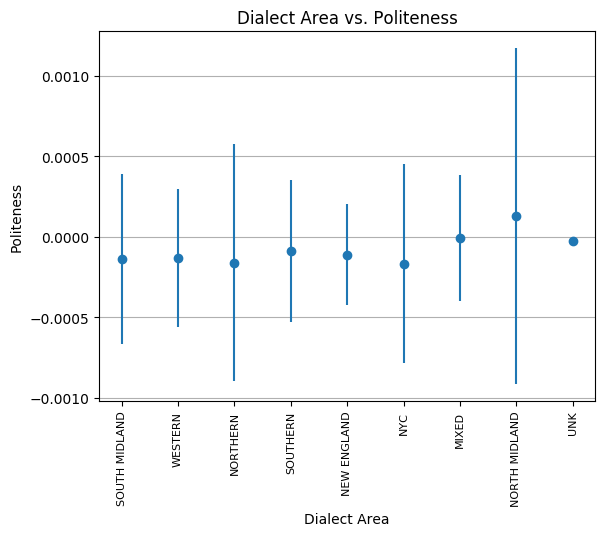

In [7]:
# Compute politeness scores for each dialect
means = []
stds = []
for d, scores in dialectPoliteness.items():
    means.append(np.mean(scores))
    stds.append(np.std(scores))

# Plot politeness scores for each dialect (error bar showing 1 standard deviation)
x = np.arange(len(means))
plt.rcdefaults()
fig, ax = plt.subplots()
ax.errorbar(x, means, yerr=stds, linestyle='None', marker='o')
ax.set_xticks(x)
ax.set_xticklabels(dialectPoliteness.keys())
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(8)
    tick.label.set_rotation('vertical')
ax.yaxis.grid(True)

plt.title('Dialect Area vs. Politeness')
plt.xlabel('Dialect Area')
plt.ylabel('Politeness')
plt.show()

### Politeness based on dialects of two users involved in a conversation

In [8]:
# Extract set of politeness feature keys
dialects = ['WESTERN', 'SOUTH MIDLAND', 'NORTHERN', 'NYC', 'NORTH MIDLAND', 'SOUTHERN', 'NEW ENGLAND', 'UNK', 'MIXED']
ddCounts = np.zeros((9,9))
ddScores = np.zeros((9,9))

for convo in switchboard_corpus.iter_conversations():
    
    # The dialect areas of two users of the conversation
    pair = [switchboard_corpus.all_users[convo.meta['from_caller']].meta['dialect_area'],
            switchboard_corpus.all_users[convo.meta['to_caller']].meta['dialect_area']]
    pair_idx = [dialects.index(dialect) for dialect in pair]
    
    convPS = initPS.copy()
    for utt in convo.iter_utterances():
        for k, v in utt.meta['politeness_strategies'].items():
            convPS[k] += v
            
    score = computePoliteness(convPS)
    ddCounts[pair_idx[0], pair_idx[1]] += 1
    
    ddScores[pair_idx[0], pair_idx[1]] += score
    
ddCounts[ddCounts == 0] = 1
avg = np.divide(ddScores, ddCounts)

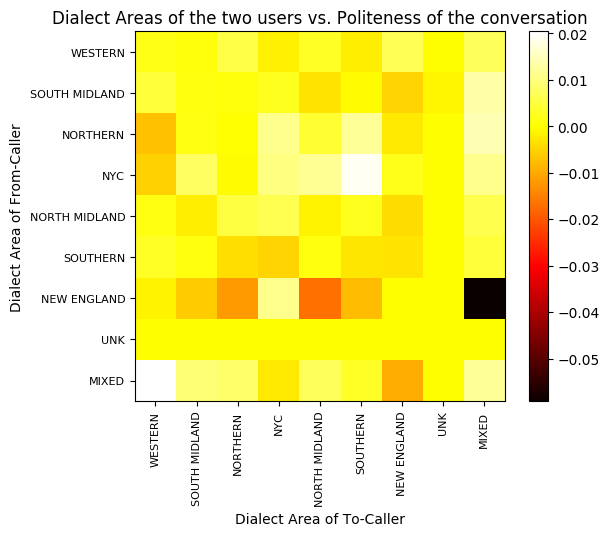

In [9]:
# Plot heat-map depending on the dialect-pair of the users involved in a conversation
# where a brighter color denotes better politeness.
# The black points are 0 simply because there were no instances for those dialect pairs
fig, ax = plt.subplots()
plt.rcdefaults()
plt.imshow(avg, cmap='hot', interpolation='nearest')
ax.set_xticks(np.arange(len(dialects)))
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(8)
    tick.label.set_rotation('vertical')
ax.set_xticklabels(dialects)
ax.set_yticks(np.arange(len(dialects)))
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(8)
ax.set_yticklabels(dialects)

plt.title('Dialect Areas of the two users vs. Politeness of the conversation')
plt.ylabel('Dialect Area of From-Caller')
plt.xlabel('Dialect Area of To-Caller')
plt.colorbar()
plt.show()

### Politeness based on education

In [10]:
# Extract set of politeness feature keys
eduCounts = {}
eduPoliteness = {}

# Get a normalized politeness feature vector for each user
for user in switchboard_corpus.iter_users():
    
    edu = user.meta['education']
    userPS = initPS.copy()
    for utt in user.iter_utterances():
        for k, v in utt.meta['politeness_strategies'].items():
            userPS[k] += v
    
    score = computePoliteness(userPS)
    
    if edu not in eduCounts:
        eduCounts[edu] = 1
        eduPoliteness[edu] = [score]
    else:
        eduCounts[edu] += 1
        eduPoliteness[edu].append(score)

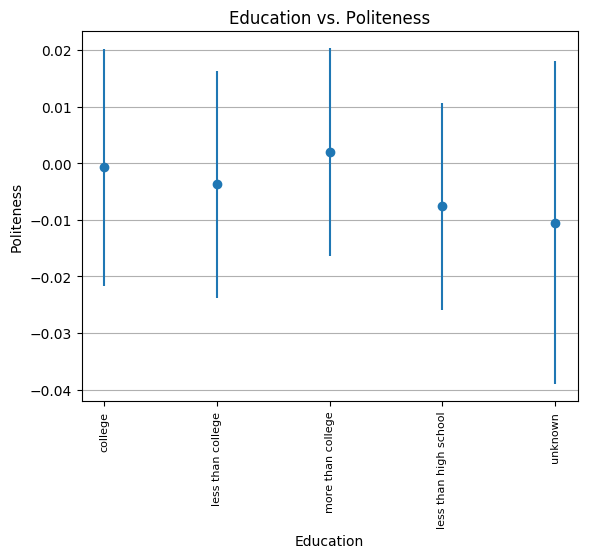

In [11]:
# Compute politeness scores for each education
means = []
stds = []
for d, scores in eduPoliteness.items():
    means.append(np.mean(scores))
    stds.append(np.std(scores))

# Plot politeness scores for each education category (error bar showing 1 standard deviation)
x = np.arange(len(means))
plt.rcdefaults()
fig, ax = plt.subplots()
ax.errorbar(x, means, yerr=stds, linestyle='None', marker='o')
ax.set_xticks(x)
ax.set_xticklabels(['college', 'less than college', 'more than college', 'less than high school', 'unknown'])
#ax.set_xticklabels(eduPoliteness.keys())
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(8)
    tick.label.set_rotation('vertical')
ax.yaxis.grid(True)

plt.title('Education vs. Politeness')
plt.xlabel('Education')
plt.ylabel('Politeness')
plt.show()

### Politeness based on different topics

In [12]:
# Measure politeness of each conversation, and store into corresponding topic
topicCounts = {}
topicPoliteness = {}
for convo in switchboard_corpus.iter_conversations():
    
    topic = convo.meta['topic_description']
    
    convPS = initPS.copy()
    for utt in convo.iter_utterances():
        for k, v in utt.meta['politeness_strategies'].items():
            convPS[k] += v
            
    score = computePoliteness(convPS)
    
    if topic not in topicCounts:
        topicCounts[topic] = 1
        topicPoliteness[topic] = [score]
    else:
        topicCounts[topic] += 1
        topicPoliteness[topic].append(score)

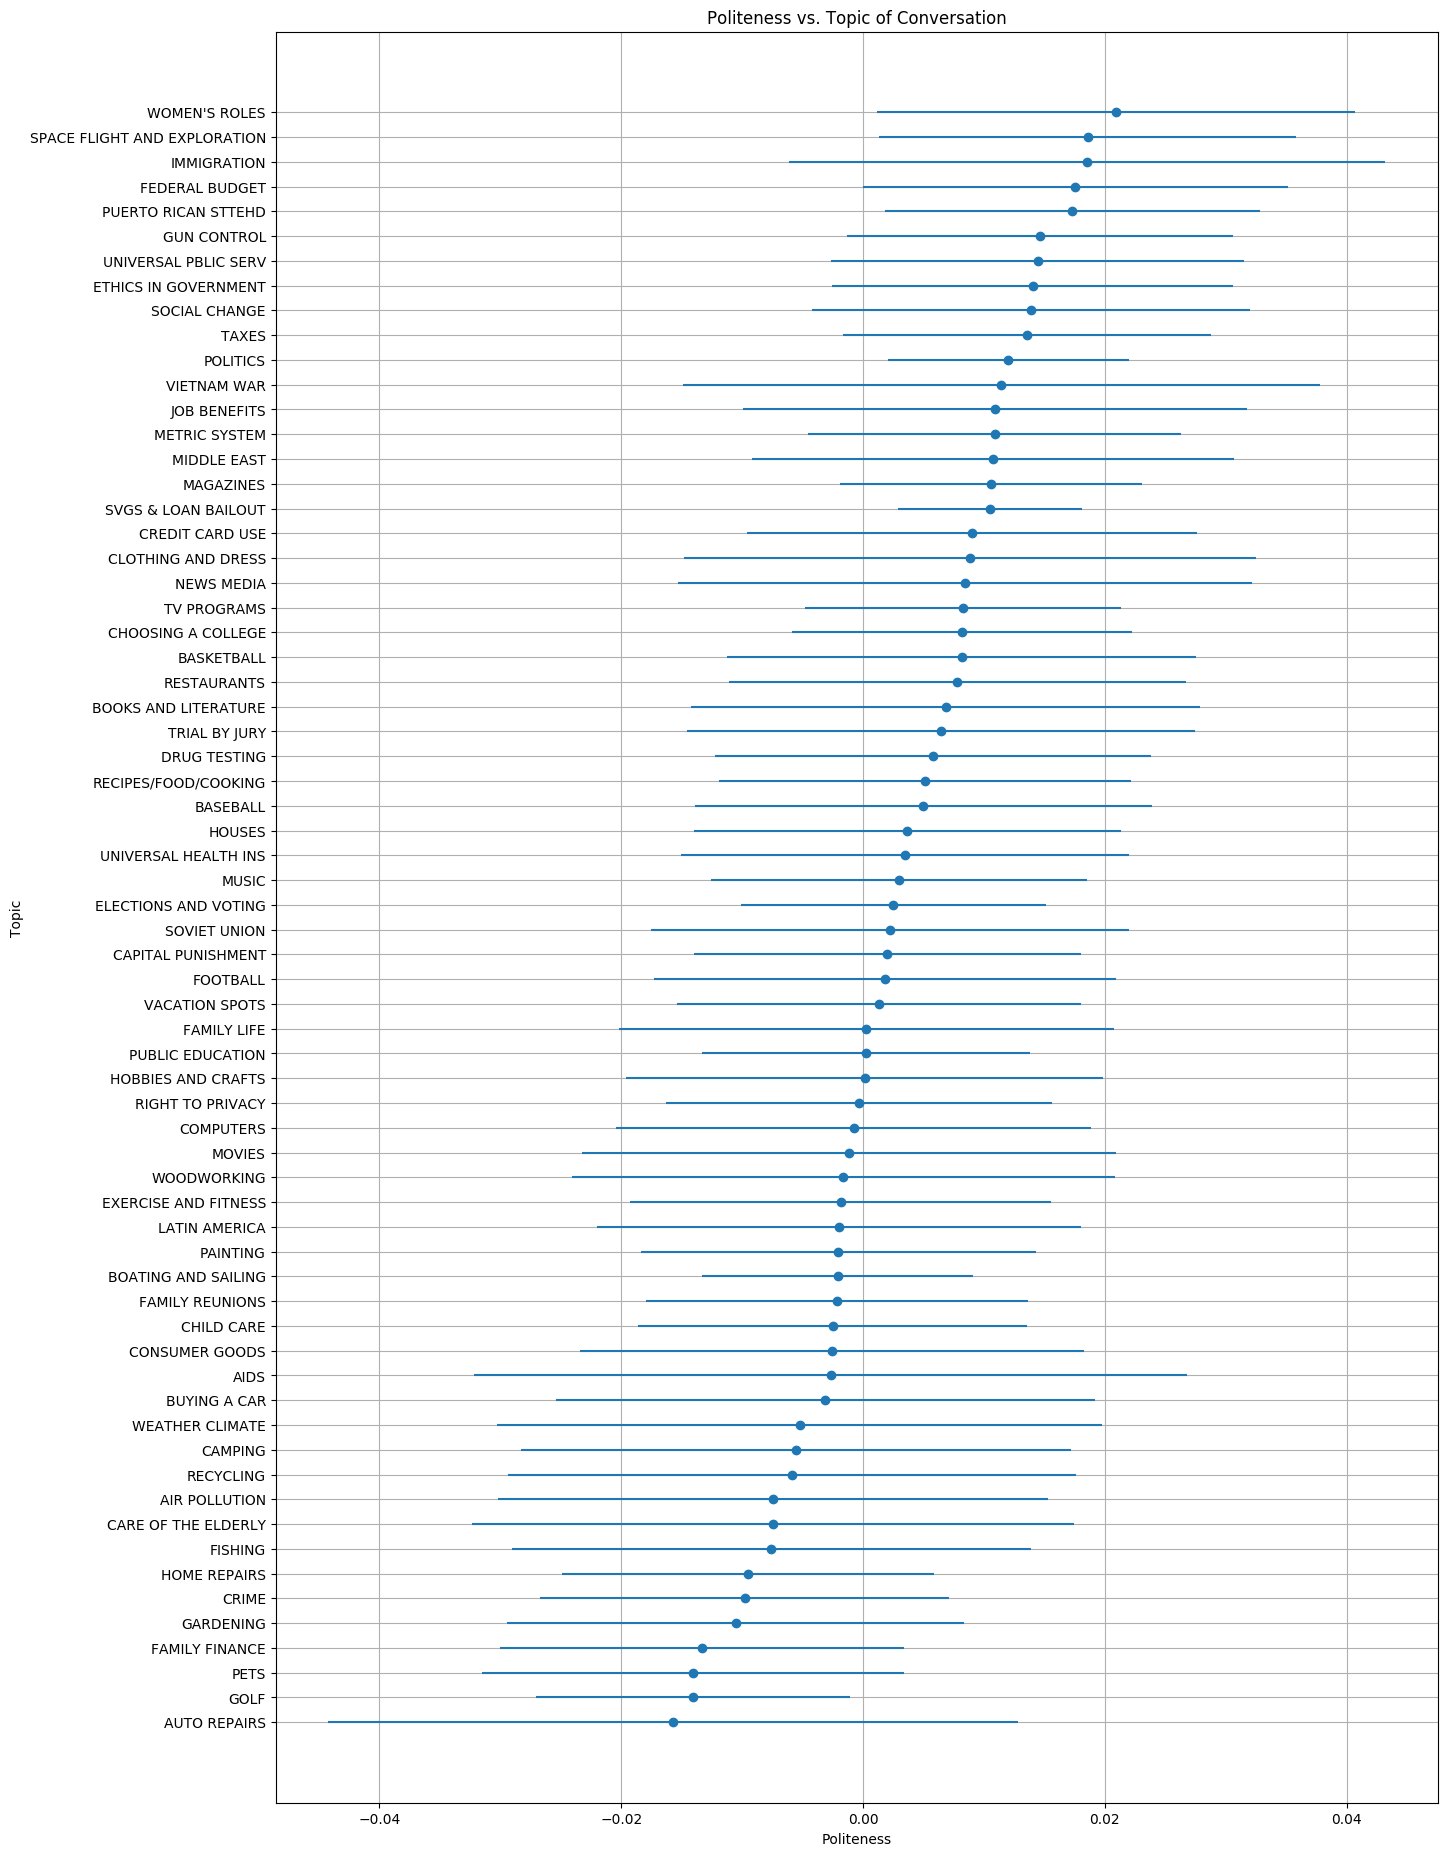

In [13]:
# Compute politeness scores for each topic
means = []
stds = []
for d, scores in topicPoliteness.items():
    means.append(np.mean(scores))
    stds.append(np.std(scores))

# Sort by the average politeness scoring
idx = np.argsort(means)
    
# Plot politeness scores for each topic (error bar showing 1 standard deviation)
x = np.arange(len(means))

means = np.array(means)
stds = np.array(stds)

plt.figure(figsize=(15, 23))
plt.errorbar(means[idx], x, xerr=stds[idx], linestyle='None', marker='o')
plt.yticks(x, [list(topicPoliteness.keys())[i] for i in idx])
plt.grid()
plt.title('Politeness vs. Topic of Conversation')
plt.xlabel('Politeness')
plt.ylabel('Topic')
plt.show()

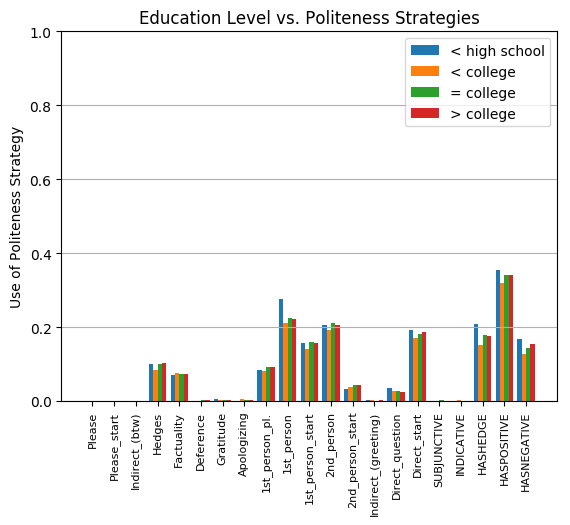

In [14]:
# See if people with different education level use different politeness strategies

# Extract set of politeness feature keys
eduPoliteness = {}

# Get a normalized politeness feature vector for each user
for user in switchboard_corpus.iter_users():
    
    edu = user.meta['education']
    userPS = defaultdict(float)
    for utt in user.iter_utterances():
        for k, v in utt.meta['politeness_strategies'].items():
            userPS[k] += v
            
    # Compute the percentage of utterances that use each politeness strategy
    for k, v in userPS.items():
        userPS[k] = v/len(user.utterances)
        
    
    if edu not in eduPoliteness.keys():
        eduPoliteness[edu] = [userPS]
    else:
        eduPoliteness[edu].append(userPS)
        

labels = [(k.split('=='))[1] for k in eduPoliteness[0][0].keys()]  

width = 0.20
means = {0:[], 1:[], 2:[], 3:[]}
for k, v in eduPoliteness.items():
    psSum = defaultdict(float)
    for ps in v:
        for strat, percent in ps.items():
            psSum[strat] += percent
    for strat in psSum.keys():
        psSum[strat] /= len(v)
    means[k] = psSum

    
x = np.arange(len(labels))
fig, ax = plt.subplots()
rects0 = ax.bar(x - 3*width/2, list(means[0].values()), width, label='< high school')
rects1 = ax.bar(x - width/2, list(means[1].values()), width, label='< college')
rects2 = ax.bar(x + width/2, list(means[2].values()), width, label='= college')
rects3 = ax.bar(x + 3*width/2, list(means[3].values()), width, label='> college')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Use of Politeness Strategy')
ax.set_title('Education Level vs. Politeness Strategies')
ax.set_xticks(x)
ax.set_xticklabels(labels)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(8)
    tick.label.set_rotation('vertical')
ax.yaxis.grid(True)
ax.set_ylim([0, 1])
ax.legend()

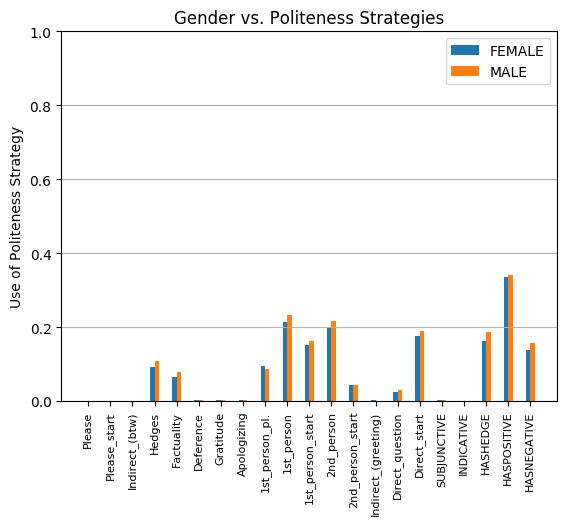

In [15]:
# See if people of different gender use different politeness strategies

# Extract set of politeness feature keys
sexPoliteness = {}

# Get a normalized politeness feature vector for each user
for user in switchboard_corpus.iter_users():
    
    sex = user.meta['sex']
    userPS = defaultdict(float)
    for utt in user.iter_utterances():
        for k, v in utt.meta['politeness_strategies'].items():
            userPS[k] += v
            
    # Compute the percentage of utterances that use each politeness strategy
    for k, v in userPS.items():
        userPS[k] = v/len(user.utterances)
        
    
    if sex not in sexPoliteness.keys():
        sexPoliteness[sex] = [userPS]
    else:
        sexPoliteness[sex].append(userPS)
        

labels = [(k.split('=='))[1] for k in sexPoliteness['FEMALE'][0].keys()]  

width = 0.20
means = {0:[], 1:[], 2:[], 3:[]}
for k, v in sexPoliteness.items():
    psSum = defaultdict(float)
    for ps in v:
        for strat, percent in ps.items():
            psSum[strat] += percent
    for strat in psSum.keys():
        psSum[strat] /= len(v)
    means[k] = psSum

    
x = np.arange(len(labels))
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, list(means['FEMALE'].values()), width, label='FEMALE')
rects2 = ax.bar(x + width/2, list(means['MALE'].values()), width, label='MALE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Use of Politeness Strategy')
ax.set_title('Gender vs. Politeness Strategies')
ax.set_xticks(x)
ax.set_xticklabels(labels)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(8)
    tick.label.set_rotation('vertical')
ax.yaxis.grid(True)
ax.set_ylim([0, 1])
ax.legend()

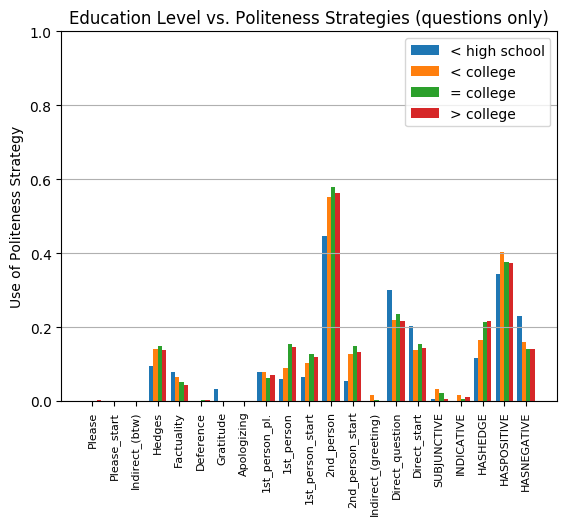

In [16]:
# Same type of experiment, but with questions only
question_tags = ['qy', 'qw', 'qy^d', 'qo', 'qh', 'qrr', 'qw^d']


# Extract set of politeness feature keys
eduPoliteness = {}

# Get a normalized politeness feature vector for each user
for user in switchboard_corpus.iter_users():
    
    edu = user.meta['education']
    userPS = defaultdict(float)
    count = 0
    for utt in user.iter_utterances():
        actTags = [pair[1] for pair in utt.meta['tag']]
        
        if any(tag in question_tags for tag in actTags):
            count += 1
            for k, v in utt.meta['politeness_strategies'].items():
                userPS[k] += v
            
    # Compute the percentage of utterances that use each politeness strategy
    for k, v in userPS.items():
        userPS[k] = v/count
        
    
    if edu not in eduPoliteness.keys():
        eduPoliteness[edu] = [userPS]
    else:
        eduPoliteness[edu].append(userPS)
        

labels = [(k.split('=='))[1] for k in eduPoliteness[0][0].keys()]  

width = 0.20
means = {0:[], 1:[], 2:[], 3:[]}
for k, v in eduPoliteness.items():
    psSum = defaultdict(float)
    for ps in v:
        for strat, percent in ps.items():
            psSum[strat] += percent
    for strat in psSum.keys():
        psSum[strat] /= len(v)
    means[k] = psSum

    
x = np.arange(len(labels))
fig, ax = plt.subplots()
rects0 = ax.bar(x - 3*width/2, list(means[0].values()), width, label='< high school')
rects1 = ax.bar(x - width/2, list(means[1].values()), width, label='< college')
rects2 = ax.bar(x + width/2, list(means[2].values()), width, label='= college')
rects3 = ax.bar(x + 3*width/2, list(means[3].values()), width, label='> college')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Use of Politeness Strategy')
ax.set_title('Education Level vs. Politeness Strategies (questions only)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(8)
    tick.label.set_rotation('vertical')
    
ax.yaxis.grid(True)
ax.set_ylim([0, 1])
ax.legend()

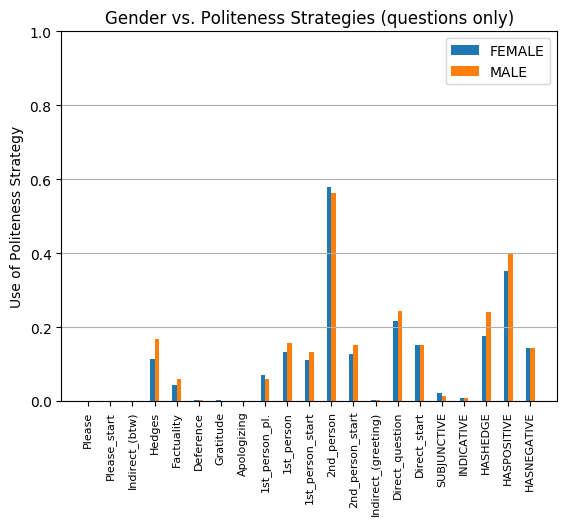

In [17]:
# Same type of experiment, but with questions only
question_tags = ['qy', 'qw', 'qy^d', 'qo', 'qh', 'qrr', 'qw^d']

# Extract set of politeness feature keys
sexPoliteness = {}

# Get a normalized politeness feature vector for each user
for user in switchboard_corpus.iter_users():
    
    sex = user.meta['sex']
    userPS = defaultdict(float)
    count = 0
    for utt in user.iter_utterances():
        actTags = [pair[1] for pair in utt.meta['tag']]
        
        if any(tag in question_tags for tag in actTags):
            count += 1
            for k, v in utt.meta['politeness_strategies'].items():
                userPS[k] += v
            
    # Compute the percentage of utterances that use each politeness strategy
    for k, v in userPS.items():
        userPS[k] = v/count
        
    
    if sex not in sexPoliteness.keys():
        sexPoliteness[sex] = [userPS]
    else:
        sexPoliteness[sex].append(userPS)
        

labels = [(k.split('=='))[1] for k in sexPoliteness['FEMALE'][0].keys()]  

width = 0.20
means = {0:[], 1:[], 2:[], 3:[]}
for k, v in sexPoliteness.items():
    psSum = defaultdict(float)
    for ps in v:
        for strat, percent in ps.items():
            psSum[strat] += percent
    for strat in psSum.keys():
        psSum[strat] /= len(v)
    means[k] = psSum

    
x = np.arange(len(labels))
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, list(means['FEMALE'].values()), width, label='FEMALE')
rects2 = ax.bar(x + width/2, list(means['MALE'].values()), width, label='MALE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Use of Politeness Strategy')
ax.set_title('Gender vs. Politeness Strategies (questions only)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(8)
    tick.label.set_rotation('vertical')
ax.yaxis.grid(True)
ax.set_ylim([0, 1])
ax.legend()